In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(sys.version_info)
for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__, module.__version__)

sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)
matplotlib 3.1.0
numpy 1.16.4
pandas 0.24.2
sklearn 0.21.2
tensorflow 2.0.0-alpha0
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all,y_train_all),(x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:] #前五千张做验证集，后五万五千张做训练集
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1,1)).reshape(-1,28,28) #先变一列，再变55000列个28*28矩阵

x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)

In [4]:
# tf.keras.models.Sequential()

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation='selu'))
    
model.add(keras.layers.AlphaDropout(rate=0.5)) 
model.add(keras.layers.Dropout(rate=0.5))
# AlphaDropout: 1.均值和方差不变  2.归一化性质也不变，所以可以和bn一起搭配
    
model.add(keras.layers.Dense(10, activation='softmax'))
#relu: y = max(0,x)
#softmax: 将向量变成概率分布

#这里用sparse的原因是y已经one hot过了，是个稀疏矩阵，如果只是一个index的话就不用sparse
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer = 'sgd',
              metrics=['accuracy'])


In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

In [6]:
#tensorboard earlystopping, modelcheckpoint

logdir = 'dnn-selu-dropout-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,
                                'fashion_mnist_model.h5')

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                   save_best_only = True),
    keras.callbacks.EarlyStopping(patience = 5, min_delta = 1e-3)
]

history = model.fit(x_train_scaled, y_train, epochs=10, 
                    validation_data=(x_valid_scaled,y_valid),
                    callbacks = callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 19s 347us/sample - loss: 1.5029 - accuracy: 0.5171 - val_loss: 0.8166 - val_accuracy: 0.7868
Epoch 2/10
55000/55000 [==============================] - 18s 324us/sample - loss: 0.8736 - accuracy: 0.7187 - val_loss: 0.7633 - val_accuracy: 0.8274
Epoch 3/10
55000/55000 [==============================] - 17s 312us/sample - loss: 0.7232 - accuracy: 0.7706 - val_loss: 0.7211 - val_accuracy: 0.8418
Epoch 4/10
55000/55000 [==============================] - 17s 317us/sample - loss: 0.6434 - accuracy: 0.7956 - val_loss: 0.7388 - val_accuracy: 0.8412
Epoch 5/10
55000/55000 [==============================] - 18s 328us/sample - loss: 0.5963 - accuracy: 0.8104 - val_loss: 0.6454 - val_accuracy: 0.8562
Epoch 6/10
55000/55000 [==============================] - 18s 324us/sample - loss: 0.5549 - accuracy: 0.8248 - val_loss: 0.6681 - val_accuracy: 0.8562
Epoch 7/10
55000/55000 [=====================

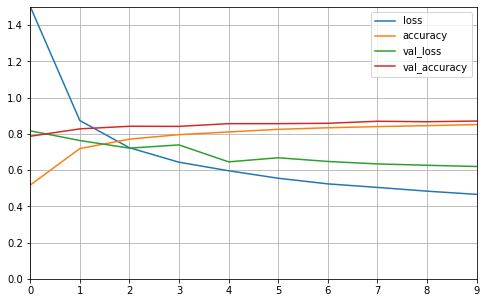

In [9]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1.5)
    plt.show()
    
plot_learning_curves(history)

1.参数众多，训练不充分
2.梯度消失， 一般发生在深度网络 -》链式法则—》复合函数求导

3.批归一化可以缓解梯度消失的问题。
4.同样， selu激活函数也可以缓解梯度消失的问题。

In [10]:
model.evaluate(x_test_scaled, y_test)

10000/10000 [==============================] - 2s 157us/sample - loss: 0.7185 - accuracy: 0.8549


[0.7184704745844006, 0.8549]